In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from multiprocessing import cpu_count
from tqdm.notebook import tqdm

import cv2
import imageio
import joblib
import os
import pickle

from PIL import Image, ImageFilter
tqdm.pandas()

In [2]:
# Mean ratio of first 10K images is 1.73, this image width/height result in a ratio of 1.75
DEBUG = True
IMG_HEIGHT = 256
IMG_WIDTH = 448
VAL_SIZE = int(100) if DEBUG else int(100e3) # 100K validation molecules
CHUNK_SIZE = 40000 # to get ~100MB TFRecords


MAX_INCHI_LEN = 200 # maximum InChI length to prevent to much padding

In [3]:
if DEBUG:
    train = pd.read_csv('/kaggle/input/bms-molecular-translation/train_labels.csv', dtype={ 'image_id': 'string', 'InChI': 'string' }).head(int(1e3))
else:
    train = pd.read_csv('/kaggle/input/bms-molecular-translation/train_labels.csv', dtype={ 'image_id': 'string', 'InChI': 'string' })

# Drop all InChI longer than MAX_INCHI_LEN - 2,  <start>InChI <end>, remove 'InChI=1S/' at start
train['InChI_len'] = train['InChI'].apply(len).astype(np.uint16)
train = train.loc[train['InChI_len'] <= MAX_INCHI_LEN - 2 + 9].reset_index(drop=True)

In [4]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image_id   966 non-null    string
 1   InChI      966 non-null    string
 2   InChI_len  966 non-null    uint16
dtypes: string(2), uint16(1)
memory usage: 17.1 KB
None


In [5]:
display(train.head(3))

,image_id,InChI,InChI_len
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...,81
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...,155
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...,158


In [6]:
if DEBUG:
    test = pd.read_csv('/kaggle/input/bms-molecular-translation/sample_submission.csv', usecols=['image_id'], dtype={ 'image_id': 'string' }).head(int(1e3))
else:
    test = pd.read_csv('/kaggle/input/bms-molecular-translation/sample_submission.csv', usecols=['image_id'], dtype={ 'image_id': 'string' })

In [7]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  1000 non-null   string
dtypes: string(1)
memory usage: 7.9 KB
None


In [8]:
display(test.head(3))

,image_id
0,00000d2a601c
1,00001f7fc849
2,000037687605


In [9]:
# Now get the Total Number of unique characters present in our InChi string
def get_vocabulary():
    tokens = ['<start>', '<end>', '<pad>']
    vocabulary = set()
    for s in tqdm(train['InChI'].values):
        vocabulary.update(s)
    return tokens + list(vocabulary)

vocabulary = get_vocabulary()

  0%|          | 0/966 [00:00<?, ?it/s]

In [10]:
# convert Inchi to Integer and save as pickle file so that we can restore it whenever we want
# Save vocabulary mappings
# , character -> integer
vocabulary_to_int = dict(zip(vocabulary, np.arange(len(vocabulary), dtype=np.int8)))

with open('vocabulary_to_int.pkl', 'wb') as handle:
    pickle.dump(vocabulary_to_int, handle)

#  integer -> character
int_to_vocabulary = dict(zip(np.arange(len(vocabulary), dtype=np.int8), vocabulary))
with open('int_to_vocabulary.pkl', 'wb') as handle:
    pickle.dump(int_to_vocabulary, handle)

## The Standard InChI is a fully standardized InChI flavor which always maintains the same level of attention to structure details and the same conventions for drawing perception. Its hashed counterpart is the Standard InChIKey.

The Standard InChI is designated by the prefix:

InChI=1S/
that is, letter ‘S’ immediately follows the version number; Standard InChI version numbers are always whole numbers.

In [11]:
# Remove the "InChI=1S/" part from the InChI strings
# It is equal for all InChI's, thus redundant or of useless while prediction
train['InChIClean'] = train['InChI'].apply(lambda InChI: '/'.join(InChI.split('=')[1].split('/')[1:]))

In [24]:
arr=train['InChIClean'].apply(lambda x: len(x))
print("10th percentile of arr : ", 
       np.percentile(arr, 10))
print("25th percentile of arr : ",
       np.percentile(arr, 25))
print("40th percentile of arr : ", 
       np.percentile(arr, 40))
print("50th percentile of arr : ", 
       np.percentile(arr, 50))

print("75th percentile of arr : ",
       np.percentile(arr, 75))
print("90th percentile of arr : ",
       np.percentile(arr, 90))
print("95th percentile of arr : ",
       np.percentile(arr, 95))
print("98th percentile of arr : ",
       np.percentile(arr, 98))
print("99th percentile of arr : ",
       np.percentile(arr, 99))

10th percentile of arr :  76.0
25th percentile of arr :  92.0
40th percentile of arr :  103.0
50th percentile of arr :  113.0
75th percentile of arr :  137.0
90th percentile of arr :  160.0
95th percentile of arr :  172.0
98th percentile of arr :  183.69999999999993
99th percentile of arr :  189.35000000000002


(array([0.01759834, 0.11076605, 0.25879917, 0.45134576, 0.59937888,
        0.75362319, 0.86438923, 0.93581781, 0.97826087, 1.        ]),
 array([ 47. ,  62.1,  77.2,  92.3, 107.4, 122.5, 137.6, 152.7, 167.8,
        182.9, 198. ]),
 [<matplotlib.patches.Polygon at 0x7f32e1fc9b50>])

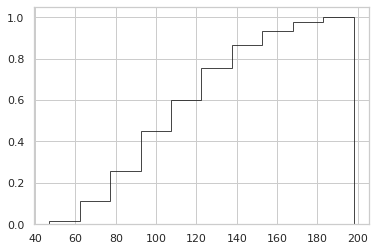

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
plt.hist(train['InChIClean'].apply(lambda x: len(x)),cumulative=True, density=True,label='CDF', alpha=0.8, color='k',histtype='step')

## As we can see from the percentile, we could have select the maximum length as 95th percentile value that is 172, but as a sake of competetion we are going to select the length as 200.

In [ ]:
# convert the InChI strings to integer lists
# start/end/pad tokens are used
def inchi_str2int(InChI):
    res = []
    res.append(vocabulary_to_int.get('<start>'))
    for c in InChI:
        res.append(vocabulary_to_int.get(c))
    
    res.append(vocabulary_to_int.get('<end>'))
    while len(res) < MAX_INCHI_LEN: 
        res.append(vocabulary_to_int.get('<pad>'))
        
    return np.array(res, dtype=np.uint8)
        
train['InChI_int'] = train['InChIClean'].progress_apply(inchi_str2int)

In [ ]:
# Now calculate Image width/Image height ratio for first 10k images on the basis of this we will decide the size of the image
ws = []
hs = []
for image_id in tqdm(train.loc[:int(10e3), 'image_id'].values):
    file_path =  f'/kaggle/input/bms-molecular-translation/train/{image_id[0]}/{image_id[1]}/{image_id[2]}/{image_id}.png'
    h, w = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE).shape
    ws.append(w)
    hs.append(h)
    
ws_mean = int(np.array(ws).mean())
hs_mean = int(np.array(hs).mean())
print(f'mean width: {ws_mean}, mean height: {hs_mean}, mean ratio: {round(ws_mean / hs_mean, 2)}')

In [ ]:
# Now divide our Train into Validation and Train Dataset
val = train.iloc[-VAL_SIZE:].reset_index(drop=True)
train = train.iloc[:-VAL_SIZE].reset_index(drop=True)
N_IMGS = len(train)

In [ ]:
print(f'Total images in the training dataset is {N_IMGS}')
print(f'Total images in the Validation dataset is {len(val)}')

In [ ]:
pd.options.display.max_colwidth = 100
display(train.head(3))

In [ ]:
print(train.info())

In [ ]:
print(val.info())

In [ ]:
# https://learnopencv.com/otsu-thresholding-with-opencv/ -> Othsu's Thresholding Algorithm
def crop(img, debug=False):
    if debug:
        fig, ax = plt.subplots(1,2, figsize=(30,8))
        ax[0].imshow(img)
        ax[0].set_title(f'original image, shape: {img.shape}', size=16)
    # In this we are going to use OTSu's Thresholding because if we are going to do it manually, during each tunnng result's will be diffrent.
    
        
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) # it needs Grey image
    #https://docs.opencv.org/master/d9/d8b/tutorial_py_contours_hierarchy.html->cv2.RETR_LIST
    contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE) #it needs black and white image
    x_min, y_min, x_max, y_max = np.inf, np.inf, 0, 0
    # https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html
    for cnt in contours:
        
        x, y, w, h = cv2.boundingRect(cnt) #cv2.boundingRect takes coordinates(x,y) and gives the Approximate Box around that object
        x_min = min(x_min, x)
        y_min = min(y_min, y)
        x_max = max(x_max, x + w)
        y_max = max(y_max, y + h)

    img_cropped = img[y_min:y_max, x_min:x_max]
    
    if debug:
        ax[1].imshow(img_cropped)
        ax[1].set_title(f'cropped image, shape: {img_cropped.shape}', size=16)
        plt.show()
    
    return img_cropped

## cv2.findContours Function

## 
The third argument in cv.findContours function. What does it denote actually?

Above, we told that contours are the boundaries of a shape with same intensity. It stores the (x,y) coordinates of the boundary of a shape. But does it store all the coordinates ? That is specified by this contour approximation method.

If you pass cv.CHAIN_APPROX_NONE, all the boundary points are stored. But actually do we need all the points? For eg, you found the contour of a straight line. Do you need all the points on the line to represent that line? No, we need just two end points of that line. This is what cv.CHAIN_APPROX_SIMPLE does. It removes all redundant points and compresses the contour, thereby saving memory.

In [ ]:
def pad_resize(img):
   
    img = cv2.resize(img,(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST) #Image resize

    return img

In [ ]:
def process_img(image_id, folder='train', debug=False):
    # read image and invert colors to get black background and white molecule
    file_path =  f'/kaggle/input/bms-molecular-translation/{folder}/{image_id[0]}/{image_id[1]}/{image_id[2]}/{image_id}.png'
    img0 = 255 - cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    
    # rotate counter clockwise to get horizontal images
    h, w = img0.shape
    if h > w:
        img0 = np.rot90(img0)
    
    img = crop(img0, debug=debug)
  
    img = pad_resize(img0)
    
    if debug:
        print('In')
        fig, ax = plt.subplots(1, 2, figsize=(20,10))
        ax[0].imshow(img0)
        ax[0].set_title('Original image', size=16)
        ax[1].imshow(img)
        ax[1].set_title('Fully processed image', size=16)
    
    # normalize to range 0-255 and encode as png
    img = (img / img.max() * 255).astype(np.uint8)
    img = cv2.imencode('.png', img)[1].tobytes()

    return img

In [ ]:
Temp=process_img('000011a64c74',debug=True)

In [ ]:
# This is used to create Chunk of TfRecords of equal Length
def split_in_chunks(data):
    return [data[i:i + CHUNK_SIZE] for i in range(0, len(data), CHUNK_SIZE)]

train_data_chunks = {
    'train': {
        'image_id': split_in_chunks(train['image_id'].values),
        'InChI': split_in_chunks(train['InChI_int'].values),
    },
    'val': {
        'image_id': split_in_chunks(val['image_id'].values),
        'InChI': split_in_chunks(val['InChI_int'].values),
    }
}

test_data_chunks = {
    'test': {
        'image_id': split_in_chunks(test['image_id'].values),
    }
}

In [ ]:
# refer: https://www.kaggle.com/xhlulu/flowers-tpu-concise-efficientnet-b7

# This is the cell where TFRecords are being generated
def make_tfrecords(data_chunks, folder='train'):
    # Try to make output folder
    try:
        os.makedirs(f'./train')
        os.makedirs(f'./val')
        os.makedirs(f'./test')
    except:
        print(f'folders already created')

    for k, v in data_chunks.items():
        for chunk_idx, image_id_chunk in tqdm(enumerate(v['image_id']), total=len(v['image_id'])):
            # process images in parallel
            jobs = [joblib.delayed(process_img)(fp, folder) for fp in image_id_chunk]
            bs = 10
            processed_images_chunk = joblib.Parallel(
                n_jobs=cpu_count(),
                verbose=0,
                require='sharedmem',
                batch_size=bs,
                backend='threading',
            )(jobs)

            # Create the TFRecords from the processed images
            with tf.io.TFRecordWriter(f'./{k}/batch_{chunk_idx}.tfrecords') as file_writer:
                if 'InChI' in v.keys(): # TRAIN/VAL, InChI included
                    for image, InChI in zip(processed_images_chunk, v['InChI'][chunk_idx]):
                        record_bytes = tf.train.Example(features=tf.train.Features(feature={
                            'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),
                            'InChI': tf.train.Feature(int64_list=tf.train.Int64List(value=InChI)),
                        })).SerializeToString()
                        file_writer.write(record_bytes)
                else: # TEST, image_id included for submission file
                    for image, image_id in zip(processed_images_chunk, image_id_chunk):
                        record_bytes = tf.train.Example(features=tf.train.Features(feature={
                            'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),
                            'image_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[str.encode(image_id)])),
                        })).SerializeToString()
                        file_writer.write(record_bytes)

make_tfrecords(train_data_chunks)
make_tfrecords(test_data_chunks, 'test')

## below cells are used for upload our dataset of TFRecords to KaggleDataset

In [ ]:
! mkdir -p /root/.kaggle/

In [ ]:
! cp ../input/apitoken/kaggle.json /root/.kaggle/kaggle.json

In [ ]:
# Get the API key for the dataset

#! cp ../input/api-token/kaggle.json /root/.kaggle/kaggle.json
! mkdir -p /kaggle/tmp/bms_train
! kaggle datasets init -p /kaggle/tmp/bms_train

In [ ]:
%%bash
echo "{
  \"title\": \"CUSTOMDATABMS\",
  \"id\": \"sudhirpol522/BMSDATA\",
  \"licenses\": [
    {
      \"name\": \"CC0-1.0\"
    }
                ]
}" > /kaggle/tmp/bms_train/dataset-metadata.json

In [ ]:
! cp -rv ./ /kaggle/tmp/bms_train

In [ ]:
! kaggle datasets create -p /kaggle/tmp/bms_train/ -u --dir-mode tar

## Below two cells shows that, the dataset that we have generated is valid or not.

In [ ]:
# convert in int encoded InChI to string
def inchi_int2char(InChI):
    res = []
    for i in InChI:
        c = int_to_vocabulary.get(i)
        if c not in ['<start>', '<end>', '<pad>']:
            res.append(c)
    return ''.join(res)

In [ ]:
# Check train TFRecords
def decode_tfrecord(record_bytes):
    features = tf.io.parse_single_example(record_bytes, {
        'image': tf.io.FixedLenFeature([], tf.string),
        'InChI': tf.io.FixedLenFeature([MAX_INCHI_LEN], tf.int64),
    })

    image = tf.io.decode_jpeg(features['image'])    
    image = tf.reshape(image, [IMG_HEIGHT, IMG_WIDTH, 1])
    image = tf.cast(image, tf.float32)  / 255.0
    
    InChI = features['InChI']
    InChI = tf.reshape(InChI, [MAX_INCHI_LEN])
    
    return image, InChI

def show_tfrecords(file_path, rows=3, cols=2):
    fig, ax = plt.subplots(rows, cols, figsize=(cols*7, rows*4))
    tfrecord = tf.data.TFRecordDataset(file_path)
    for idx, (image, InChI) in enumerate(tfrecord.map(decode_tfrecord).take(rows*cols)):
        if idx == 0:
            print(f'first InChI int: {InChI}')
            print(f'first InChI char {inchi_int2char(InChI.numpy())}')
        image = tf.cast(image * 255, tf.uint8)
        image = tf.squeeze(image)
        row, col = idx // cols, idx % cols
        ax[row, col].imshow(image)

    plt.show()

print('TRAIN BATCH')
show_tfrecords(f'./train/batch_0.tfrecords')
print('VAL BATCH')
show_tfrecords(f'./val/batch_0.tfrecords')